In [1]:
#################################################
################  Import things #################
#################################################

import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import lsmr
import jax
import jax.numpy as jnp
import jax.experimental as jexp
from jax.experimental import sparse as jexps
import networkx as nx
from math import exp
from functools import partial
import timeit
import random
import copy
import matplotlib.pyplot as plt
#import tensorflow as tf
#from tensorflow.keras.datasets import mnist
from sklearn import datasets
import pickle

## here are the user-defined functions and classes
from MarkovComputations import WeightMatrix, InputData, get_input_inds, get_output_inds, random_initial_parameters, compute_error, downsample_avg, load_and_format_mnist, load_and_format_iris, evaluate_accuracy, evaluate_accuracy_per_class

1
2
3
4
5
6
7
8


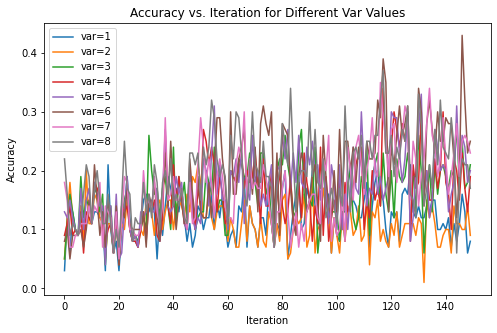

In [7]:
input_file = "/Users/csfloyd/Library/CloudStorage/Dropbox/Projects/MarkovComputation/Dirs/"
input_file = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/Dirs/M_10/"

var_list = [60, 70, 80, 90, 100]
var_list = [1,2,3,4,5,6,7,8]


plt.figure(figsize=(8, 5))

for var in var_list:
    print(var)
    with open(input_file + str(var) + "/SavedData.pkl", 'rb') as file:
        weight_matrix, input_data, accuracy_list, input_inds, output_inds = pickle.load(file)

    plt.plot(accuracy_list, label=f"var={var}")

    
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Iteration for Different Var Values")
plt.legend()
plt.show()

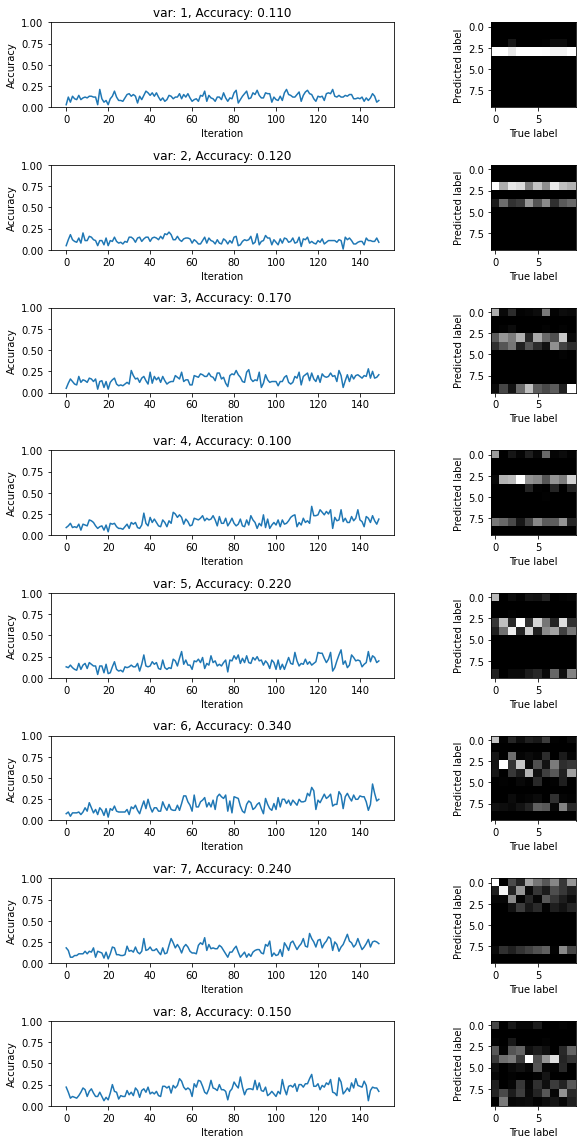

In [9]:
fig, axes = plt.subplots(len(var_list), 2, figsize=(10, 2 * len(var_list)))

n_classes = 10
for i, var in enumerate(var_list):
    with open(input_file + str(var) + "/SavedData.pkl", 'rb') as file:
        weight_matrix, input_data, accuracy_list, input_inds, output_inds = pickle.load(file)

    res = evaluate_accuracy(weight_matrix, input_inds, input_data, output_inds, n_classes, 100)
    predictions_per_class = evaluate_accuracy_per_class(weight_matrix, input_inds, input_data, output_inds, 100, n_classes)

    # Plot accuracy curve
    axes[i, 0].plot(accuracy_list)
    axes[i, 0].set_title(f"var: {var}, Accuracy: {res:.3f}")
    axes[i, 0].set_xlabel("Iteration")
    axes[i, 0].set_ylabel("Accuracy")
    axes[i, 0].set_ylim(0,1)

    # Show predictions per class
    im = axes[i, 1].imshow(predictions_per_class, cmap='gray')
    axes[i, 1].set_xlabel("True label")
    axes[i, 1].set_ylabel("Predicted label")

fig.tight_layout()
plt.show()

In [23]:
input_file = "/Users/csfloyd/Library/CloudStorage/Dropbox/Projects/MarkovComputation/Dirs/"
input_file = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/Dirs/"

with open(input_file + "SavedData.pkl", 'rb') as file:
    weight_matrix, input_data, accuracy_list, input_inds, output_inds = pickle.load(file)

# file = input_file + "SavedData.pkl"
# print(file)
# weight_matrix, input_data, accuracy_list = pickle.load(file)

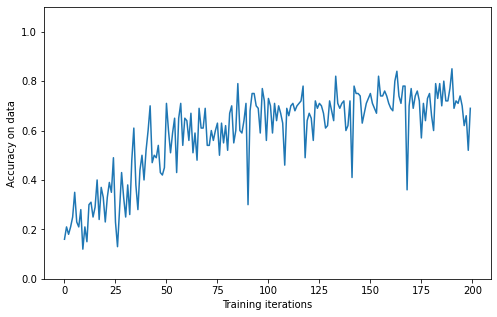

In [24]:
################################################
################  Plot results #################
################################################



### plot the accuracy
plt.figure(figsize=(8, 5))
plt.plot(accuracy_list)
plt.xlabel("Training iterations")
plt.ylabel("Accuracy on data")
plt.ylim(0,1.1)
#plt.xlim(0,n_training_iters / training_stride)
plt.show()




0.758


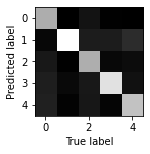

In [26]:

###################################################
################  Get predictions #################
###################################################

n_classes = len(input_data.training_data)
print(evaluate_accuracy(weight_matrix, input_inds, input_data, output_inds, n_classes, 500))
predictions_per_class = evaluate_accuracy_per_class(weight_matrix, input_inds, input_data, output_inds, 500, n_classes)

plt.figure(figsize=(10, 2))
plt.imshow(predictions_per_class, cmap='gray')  # Show in grayscale
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()


In [9]:
print("a" + "b")

ab
